In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import sys
sys.path.append("..")
import autoaim

# Devices
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Device: GPU.')
else:
    device = torch.device('cpu')
    print('Device: CPU.')

Device: CPU.


In [56]:
# Dataset
header, data = autoaim.DataLoader('test.csv').read_csv()
data = torch.Tensor(data).to(device)
# x_train = data[:, [0,2]]
# x_train = torch.cat((x_train,x_train*x_train,x_train*x_train*x_train),1)
max = torch.max(x_train,0)[0]
min = torch.min(x_train,0)[0]
x_train = (x_train-min)/(max-min)
y_train = data[:, -1:]

test_data = torch.Tensor([
    [1.2/50, 0.0],
    [0.0186, 0.844]
]).to(device)

In [51]:
# Parameter
epoch_num = 10000
learning_rate = 0.003
train_dataset_size = x_train.size(0)
input_size = x_train.size(1)
output_size = 1

print('====== Config ======')
print('train_dataset_size: {}'.format(train_dataset_size))
print('input_size: {}'.format(input_size))
print('learning_rate: {}'.format(learning_rate))
print('epoch_num: {}'.format(epoch_num))


class Model(torch.nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        y_pred = self.sigmoid(self.linear(x))
        return y_pred


model = Model().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
print('====== Train ======')
for epoch in range(epoch_num):
    # Forward pass
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch+1) % (epoch_num/100) == 0:
        print("Epoch: [{!s:4}/{!s:4}], Loss: {:.2f}"
              .format(epoch+1, epoch_num, loss))

====== Config ======
train_dataset_size: 47
input_size: 2
learning_rate: 0.003
epoch_num: 10000
====== Train ======
Epoch: [1   /10000], Loss: 0.25
Epoch: [100 /10000], Loss: 0.25
Epoch: [200 /10000], Loss: 0.24
Epoch: [300 /10000], Loss: 0.24
Epoch: [400 /10000], Loss: 0.24
Epoch: [500 /10000], Loss: 0.24
Epoch: [600 /10000], Loss: 0.24
Epoch: [700 /10000], Loss: 0.24
Epoch: [800 /10000], Loss: 0.24
Epoch: [900 /10000], Loss: 0.24
Epoch: [1000/10000], Loss: 0.24
Epoch: [1100/10000], Loss: 0.24
Epoch: [1200/10000], Loss: 0.24
Epoch: [1300/10000], Loss: 0.23
Epoch: [1400/10000], Loss: 0.23
Epoch: [1500/10000], Loss: 0.23
Epoch: [1600/10000], Loss: 0.23
Epoch: [1700/10000], Loss: 0.23
Epoch: [1800/10000], Loss: 0.23
Epoch: [1900/10000], Loss: 0.23
Epoch: [2000/10000], Loss: 0.23
Epoch: [2100/10000], Loss: 0.23
Epoch: [2200/10000], Loss: 0.23
Epoch: [2300/10000], Loss: 0.23
Epoch: [2400/10000], Loss: 0.23
Epoch: [2500/10000], Loss: 0.23
Epoch: [2600/10000], Loss: 0.23
Epoch: [2700/10000],

====== Test ======
[-0.49832502 -0.19669285 -0.45377687]
tensor([[0.3856],
        [0.3477]], device='cuda:0', grad_fn=<SigmoidBackward>)


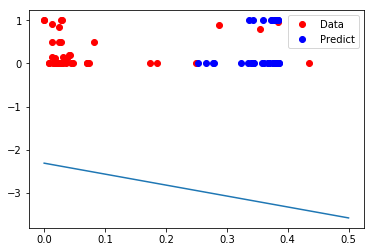

In [57]:
# Test the model
print('====== Test ======')
w = [x.data.cpu() for x in model.parameters()]
w = torch.cat((w[0][0],w[1])).numpy()
print(w)
print(model(test_data))
with torch.no_grad():
    y_pred = model(x_train)
    # print(torch.cat((y_pred, y_train), 1))
    device_cpu = torch.device('cpu')
    # dots
    y_pred_plot = y_pred.to(device_cpu).numpy()
    y_train_plot = y_train.to(device_cpu).numpy()
    _ = np.where(y_train.to(device_cpu).numpy()==1)
    x_train_true_plot = x_train[_].to(device_cpu).numpy()
    _ = np.where(y_train.to(device_cpu).numpy()==0)
    x_train_false_plot = x_train[_].to(device_cpu).numpy()
    plt.plot(x_train_plot[:, 0], x_train_plot[:, 1], 'ro', label='Data')
    plt.plot(y_pred_plot, y_train_plot, 'bo', label='Predict')
    # line
    x = np.linspace(0,0.5)
    a,b,c = w[0],w[1],w[2]
    plt.plot(x, -c/b-a/b*x, linestyle='-')
    plt.legend()
    plt.show()


In [59]:
epoch_num = 200000
learning_rate = 0.001
input_size = x_train.size()[1]
output_size = 1

print('====== Config ======')
print('input_size: {}'.format(input_size))

# Weight (plus one for constant term)
w = torch.rand((input_size + 1, output_size),
               requires_grad=True, device=device)

def forward(x):
    constant_term = torch.ones(x.size()[0], 1, device=device)
    _x = torch.cat((x, constant_term), 1)
    y_pred = _x.mm(w)
    y_pred = torch.sigmoid(y_pred)
    return y_pred

# Loss function


def loss(x, y):
    y_pred = forward(x)
    return ((y_pred - y) * (y_pred - y)).sum() + w.abs().sum()

print('====== Start training ======')
# Training loop
for epoch in range(epoch_num):
    l = loss(x_train, y_train)
    l.backward()
    w.data = w.data - learning_rate * w.grad.data

    if epoch == 0 or (epoch+1) % (epoch_num/100) == 0:
        print("progress: {!s:4}, loss: {:.2f}".format(epoch+1, l.data))
        # print('             grad: {}'.format(w.grad))

    # Manually zero the gradients after updating weights
    w.grad.data.zero_()

====== Config ======
input_size: 2
====== Start training ======
progress: 1   , loss: 21.76
progress: 2000, loss: 11.32
progress: 4000, loss: 11.32
progress: 6000, loss: 11.32
progress: 8000, loss: 11.32
progress: 10000, loss: 11.32
progress: 12000, loss: 11.32
progress: 14000, loss: 11.32
progress: 16000, loss: 11.32
progress: 18000, loss: 11.32
progress: 20000, loss: 11.32
progress: 22000, loss: 11.32
progress: 24000, loss: 11.32
progress: 26000, loss: 11.32
progress: 28000, loss: 11.32
progress: 30000, loss: 11.32
progress: 32000, loss: 11.32
progress: 34000, loss: 11.32
progress: 36000, loss: 11.32


KeyboardInterrupt: 

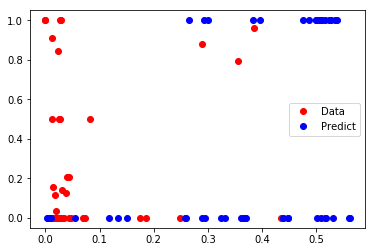

In [19]:

with torch.no_grad():
    correct = 0
    total = 0
    y_pred = forward(x_train)
    # print(torch.cat((y_pred, y_train), 1))
    device_cpu = torch.device('cpu')
    y_pred_plot = y_pred.to(device_cpu).numpy()
    y_train_plot = y_train.to(device_cpu).numpy()
    x_train_plot = x_train.to(device_cpu).numpy()
    _ = np.where(y_train.to(device_cpu).numpy()==1)
    x_train_true_plot = x_train[_].to(device_cpu).numpy()
    _ = np.where(y_train.to(device_cpu).numpy()==0)
    x_train_false_plot = x_train[_].to(device_cpu).numpy()
    plt.plot(x_train_plot[:, 0], x_train_plot[:, 1], 'ro', label='Data')
    plt.plot(y_pred_plot, y_train_plot, 'bo', label='Predict')
    plt.legend()
    plt.show()